In [1]:
%matplotlib inline

In [2]:
from akeyzerr_ds2021_exam_code import *

successful_imports()

'Imports from akeyzerr_exam module have been successful'

# Akeyzerr's Project for SoftUni's Data Science 2021 course


# Is loud music being reviewed more favourable?
## A hypothesis testing via data analysis from Spotify and Pitchfork

### __ABSTRACT:__
Based on the statement that "loud music is good music", this study tries to find some correlation between a positive review score and the overall loudness of the author's music. Expectation: The louder the songs for a year, the greater the average review scores in the year. Hence, we expect a positive relationship.

#### Data sources considered 
For the music data a few data sources were considered.
* [Dynamic Range DB](https://dr.loudness-war.info/) - an online database that is systematically measuring the dynamic range of recordings. The best source of information on cd/lp sound quality. Would be a great source if the focus of this study was data gathering and web scraping.
* [Million Song Datase](http://millionsongdataset.com/) - a freely-available collection of audio features and metadata for a million contemporary popular music tracks. Enormous source for future projects - literally, 280 GBs worth of data. A subset of 10'000 songs is available for download, but it is almost 2GB in size.
* [Free Music Archive](https://arxiv.org/abs/1612.01840) - is an online repository of royalty-free music. Provides an open and easily accessible dataset suitable for evaluating, browsing, searching, and organizing large music collections. Could be an interesting project to implement a loudness-calculating algorithm and apply it to this music collection. That dataset is over 1TB of music data, or approx. 350MB of its metadata.

#### Data used
Two datasets are being used. The first one contains desired data for some audio tracks, and the second one has data for reviews on some albums. This study demonstrates corelation (or lack there of) between music loudness data through the years and the scoring from reviews in the same time period.

#### The terminology
Sound loudness is a great and kind of a controversial topic. The percieved loudness of a sound signal corelates to its dynamic range, but that's outside the scope of this study. [Here](https://dynamicrangeday.co.uk/resources/) can be found some great sources of information on the subject.

The quick graph "Dynamic Range vs Loudness" shows an established sample data from Dynamic Range DB. It doesn't show the inversely proportional corelation between ```dynamic range``` and ```percieved loudness```, but lists few albums and their measured and averaged loudness. It shows that older records tend to be less "loud" and with wider dynamic range (optimized for the recording medium by sound engineers, recording engineers and producers who knew what they're doing). 

From [Spotify API docs:](https://developer.spotify.com/documentation/web-api/reference/#category-tracks)
__loudness - float__ ```
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.``` 

##### DISCLAIMER
Due to the nature of this study, being an exam project, the scope and granularity of the data used is highly limited. The conclusion should not be taken at face value.

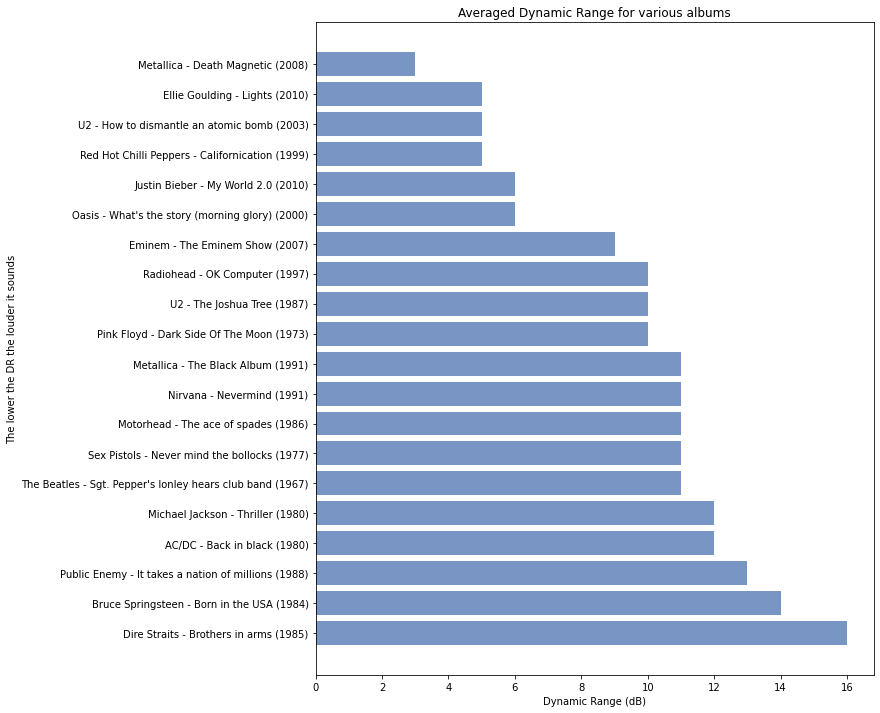

In [3]:
dr_df = pd.read_csv('./data/dr_sample.csv', index_col='index')
dr_df['full_title'] = dr_df.artist + ' - ' + dr_df.title + ' (' + dr_df.year.astype('str') + ')'
plt.style.use('seaborn-deep')
plt.figure(figsize=(10,12))
plt.barh(np.arange(len(dr_df.full_title.tolist())), dr_df.dynamic_range.tolist(), align='center', alpha=.75)
plt.ylabel('The lower the DR the louder it sounds')
plt.yticks(np.arange(len(dr_df.full_title.tolist())), dr_df.full_title.tolist())
plt.title('Averaged Dynamic Range for various albums')
plt.xlabel('Dynamic Range (dB)')
plt.show() 

### STRUCTURE

The study has the following structure: 
* Ingesting a CSV dataset, containing data for approx. 170k music titles from Spotify API;
    * Cleaning and tidying the data for our goals;
    * Basic EDA and a secondary hypothesis testing; 
    * Interpolating new data from the sampled dataset about artist's average loudness, average loudness per year, ets.;
* Ingesting a SQLite3 dataset with reviews, scraped by N.Conaway from the online music publication Pitchfork
    * Cleaning and tidying the data for our goals;
    * Interpolating data about artist's review scores
    * Interpolating data about review scores through the years (covered by this magazine);
* Cross-linking artists, years and data between the two datasets and ... 
* Showing the results in a graphs and drawing a conclusion.


### CODE

The language used in this project is ```Python```, as per requisite. The libraries used are Numpy, Pandas and Matplotlib.
All significant custom functions developed for this study reside in the ```akeyzerr_ds2021_exam_code``` module.

# First Dataset - Spotify Dataset 1922-2021

The first data setis the [Yamac Eren Ay's](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data_o.csv) collection from Spotify's API. We will focus on the loudness data of the songs included. 

This study was in parts inspired by the following articles on this dataset:
* [Visualizing Spotify Songs with Python](https://towardsdatascience.com/visualizing-spotify-songs-with-python-an-exploratory-data-analysis-fc3fae3c2c09);
* [Exploratory Data Analysis on Spotify Dataset](https://jovian.ai/gohilbhagyaraj17/exploratory-data-analysis-on-spotify-dataset);



In [4]:
# billboard_df = pd.read_csv('./data/billboard_2000_2018_spotify_lyrics.csv')
spotify_df = pd.read_csv('./data/data_o.csv')

# Getting to know the data:

# spotify_df.info()
spotify_df.tail()
# spotify_df.isnull().sum()
# spotify_df.duplicated().sum()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
170648,0.608,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.734,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.637,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.195,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
170652,0.642,2020,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.1820,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


We'll drop the columns of no interest, i.e. the spotify links, songs IDs, video links, etc.
##### Clarification
The first few drafts of this study made use of a much smaller dataset, but again from Spotify's API. The [Billboard Hot 100]('https://data.world/typhon/billboard-hot-100-songs-2000-2018-w-spotify-data-lyrics') had pulled a different set of track features form Spotify's API. Clearly, the larger dataset doesn't have ```broad_genre```, ```spotify_links```, etc. features present. These have been left in the final study for backwards compatibility and in case the the smaller dataset needs to be used again.

In [5]:
columns_of_no_interest = ['simple_title',
                          'main_artist',
                          'weeks',
                          'change',
                          'spotify_link',
                          'spotify_id',
                          'video_link',
                          'genre',
                          'broad_genre',
                          'analysis_url',
                          'tempo', 
                          'time_signature',
                          'key',
                          'mode',
                          'lyrics',
                          'id',
                          'explicit',
                          'popularity',
                         ]

spotify_df.drop(columns=columns_of_no_interest, inplace=True, errors='ignore')
# spotify_df.info()

Some of the atributes (like ```speechiness```, ```acousticness```, ```instrumentallness```, etc.), although interesting, for the time being are of low interest for the goals of this study and will be droped from the dataframe. ```name``` was excluded in the first drafts, but later used to interpolate artist's loudness values and tracks count per year.

In [6]:
columns_of_low_interest = ['liveness', 
                          'speechiness',
                          'acousticness',
                          'instrumentalness',
                          'danceability',
                          'valence',
                          'peak_pos',
                          'last_pos',
                          'rank',
                          'energy',
                          'duration_ms',
#                           'name',
                          ]

spotify_df.drop(columns=columns_of_low_interest, inplace=True, errors='ignore')
# spotify_df.duplicated().value_counts()
spotify_df.drop_duplicates(inplace=True)
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168563 entries, 0 to 170652
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          168563 non-null  int64  
 1   artists       168563 non-null  object 
 2   loudness      168563 non-null  float64
 3   name          168563 non-null  object 
 4   release_date  168563 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 7.7+ MB


In [7]:
# spotify_df.isna().sum()
spotify_df.sample()

,year,artists,loudness,name,release_date
12179,1982,['Orange Juice'],-9.357,Rip It Up,1982-11-01


After dropping almost all of the data, we still have some cleaning, tidying and interpolating to do.

* the ```date``` column is not ```datetime64```;
* we'll round the ```loudness``` data to 2 decimals;
* ```artists``` column consists of multiple artists. We'll use only the first entry;
* the ```year``` column should be a category;
* interpolating values for ```mean loudness per artist``` and others for further use.

In [8]:
# Tidying the date and year columns

temp_date = pd.to_datetime(spotify_df.release_date, format='%Y-%m-%d')
spotify_df['release_date'] = temp_date
spotify_df.year = spotify_df['year'].astype('category')
# spotify_df.sample()
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168563 entries, 0 to 170652
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          168563 non-null  category      
 1   artists       168563 non-null  object        
 2   loudness      168563 non-null  float64       
 3   name          168563 non-null  object        
 4   release_date  168563 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 6.6+ MB


In [9]:
# Tidying the loudness column

spotify_df.loudness = spotify_df.loudness.round(2)
columns_to_rename = {'release_date' : 'date',
                     'artists' : 'artist_y',}
spotify_df.rename(columns = columns_to_rename, inplace=True, errors='ignore')
# new_column_order = [0, 3, 1, 2]
# spotify_df = spotify_df[spotify_df.columns[new_column_order]]
# spotify_df.info()
# spotify_df.sort_values('date', ascending=True, inplace=True)
# spotify_df.reset_index(inplace=True)

In [10]:
# Tidying the artists column with a custom function

spotify_df = artists_list_to_artist(spotify_df, column='artist_y')
spotify_df.artist_y = spotify_df.artist_y.str.lower()
spotify_df.sample()
# spotify_df.info()

,year,artist_y,loudness,name,date
31522,1985,dead kennedys,-5.11,Soup is Good Food,1985-12-21


In [11]:
# Interpolating mean loudness and other values per artist

spotify_df['artist_mean_loudness_per_year'] = spotify_df.groupby(['artist_y', 'year']).loudness.transform('mean').round(2)
spotify_df['artist_mean_loudness'] = spotify_df.groupby(['artist_y']).loudness.transform('mean').round(2)
spotify_df['artist_songs_per_year'] = spotify_df.groupby(['artist_y', 'year']).name.transform('count')

spotify_df.iloc[952]
# spotify_df.melt(id_vars=('year', 'artist_y', 'name'))

year                                                                1926
artist_y                         jelly roll morton & his red hot peppers
loudness                                                          -10.35
name                                                           The Chant
date                                                 1926-01-01 00:00:00
artist_mean_loudness_per_year                                     -10.33
artist_mean_loudness                                              -10.33
artist_songs_per_year                                                 14
Name: 963, dtype: object

In [12]:
spotify_df.melt(id_vars=('year', 'artist_y', 'name'))
# spotify_df.loc[spotify_df.artist_y == 'louis armstrong']
# spotify_df[(spotify_df['artist_y'] == 'louis armstrong') & (spotify_df['year'] == 1953)]

,year,artist_y,name,variable,value
0,1921,sergei rachmaninoff,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",loudness,-20.1
1,1921,dennis day,Clancy Lowered the Boom,loudness,-12.44
2,1921,khp kridhamardawa karaton ngayogyakarta hadini...,Gati Bali,loudness,-14.85
3,1921,frank parker,Danny Boy,loudness,-9.32
4,1921,phil regan,When Irish Eyes Are Smiling,loudness,-10.1
...,...,...,...,...,...
842810,2020,anuel aa,China,artist_songs_per_year,23
842811,2020,ashnikko,Halloweenie III: Seven Days,artist_songs_per_year,3
842812,2020,mamamoo,AYA,artist_songs_per_year,2
842813,2020,eminem,Darkness,artist_songs_per_year,5


We now have clean and tidy data with info on artists and their average loudness.

## Loudness creep through the years. 
### And a sample artist's loudness analysis

One hypothesis in the music industry is that the loudness through the years has increased. And we can show if it's true simply by plotting the average loudness data we have for the songs of that year. Note that we do not know how was the loudness calculated in the Spotify's library of songs.

Also, the loudness data provided by the Spotify's API is in decibells (presumably in $dB_{FS}$), and not in the industry standard $LU_{FS}$.

For the sample artists we will look into Louis Armstrong.

In [13]:
loudness_per_year = spotify_df.groupby('year')['loudness'].agg(np.mean)
print(loudness_per_year.sample(10))

year
2015    -7.628387
1947   -14.377636
1955   -13.842400
1934   -14.756920
1928   -16.482302
1949   -15.473390
1922   -19.275070
1927   -14.748372
1986   -11.115698
1959   -14.433358
Name: loudness, dtype: float64


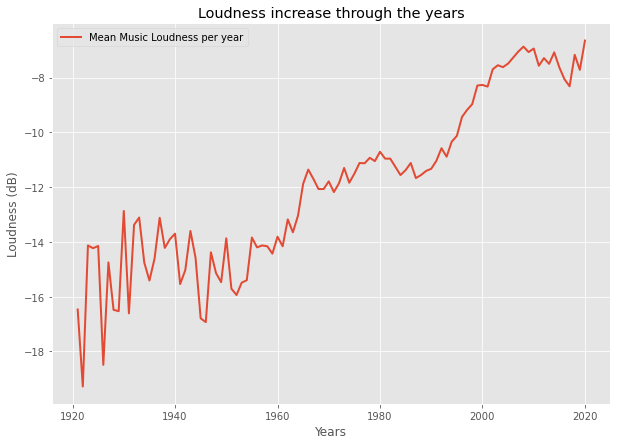

In [14]:
loudness_per_year = spotify_df.groupby('year')['loudness'].agg(np.mean).round(2).reset_index()
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(loudness_per_year['year'], loudness_per_year['loudness'], lw=2)
# plt.ylim(-10,-1)
plt.xlabel('Years')
plt.ylabel('Loudness (dB)')
plt.title('Loudness increase through the years')
plt.legend({'Mean Music Loudness per year':1, 'Louis Armstrong\'s songs mean loudness per year':2})
plt.show()

As presented in the graph, that hypothesis checks out.

We will now test that hypothesis over a single artist. That wouldn't produce result of statistical significance  because a larger sample of individual artists should be tested.

Also, these analyses omit crucial factors such as the genre of the songs, the technical capabilities in the era of the recordings, wether the songs measured have been remastered, the ADC methods used, etc. As such, the following graph has only illustrative purpose.

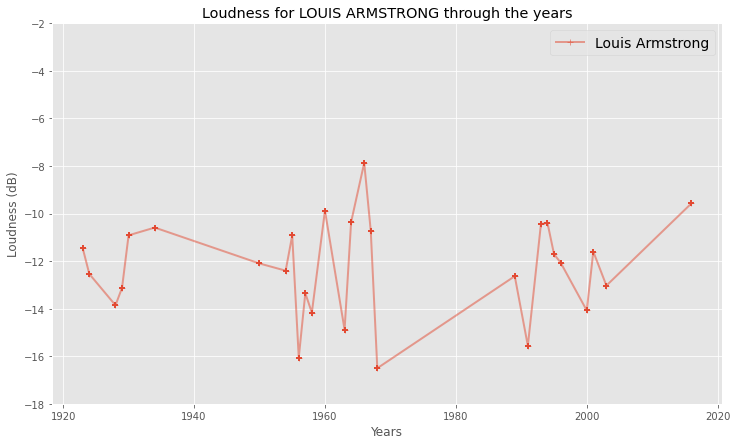

In [15]:
graph_loudnes_per_artist(spotify_df, ['louis armstrong'])

Looking at the graph based on the sampled artist data, we cannot find a strong (if any) support for the hypothesis that the loudness increases with years passing. Also, we do not know if the "louder" tracks for this particular artist haven't been remastered "for the new listeners who want loud music".

We will expand the sampled data for few more artists. Feel free to add more artists in the list.

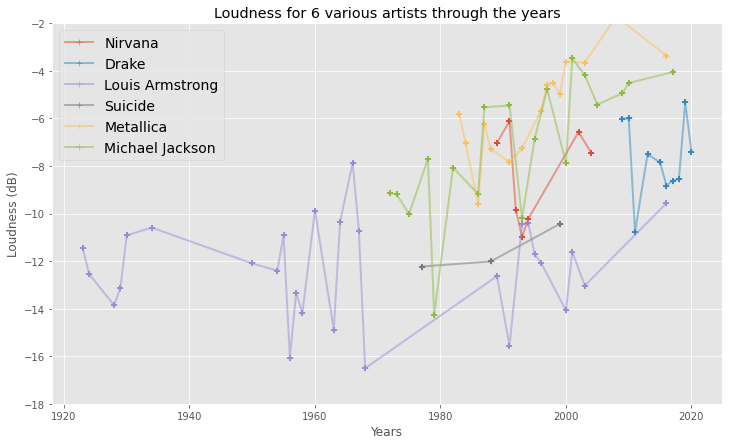

In [16]:
graph_loudnes_per_artist(spotify_df, ['nirvana', 'drake', 'louis armstrong', 'suicide', 'metallica', 'michael jackson'])

The upward trend for the loudness values is getting clearer.

### The loudness creep for the years ~1995-2020.

Here we are focusing on a time period  between 1995 and 2020. The normalized graph doesn't look that scary, but in all fairness, the infamous "Loudness war" officialy ended around 2005-2007 with the implementation of the ITU and EBU loudness standards. The graph supports that statement. 

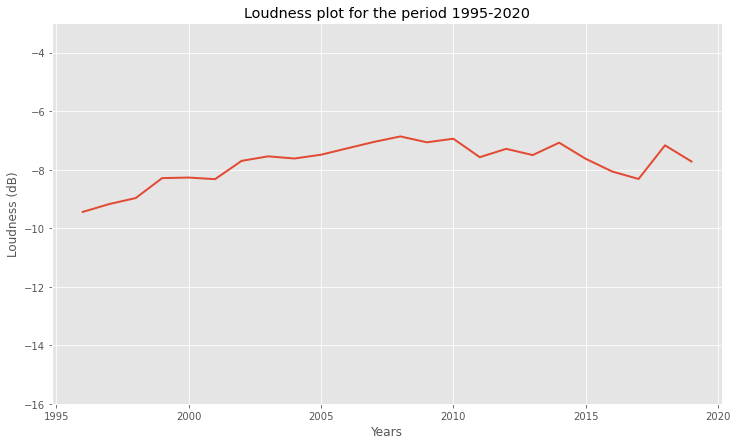

In [17]:
loudness_per_year = spotify_df.groupby('year')['loudness'].agg(np.mean)
plt.figure(figsize=(12,7))
plt.plot(spotify_df.year.unique()[75:-1], loudness_per_year[75:-1], lw=2)
plt.ylim(-16, -3)
plt.xlabel('Years')
plt.ylabel('Loudness (dB)')
plt.title('Loudness plot for the period 1995-2020')
plt.show()

# Ingesting the reviews data from Pitchfok magazine

Gorgeously illustrated and eye-opening data science analysis publication on the [Nolan Conaway's Pitchfork reviews scrapped data](https://nolanbconaway.github.io/blog/2017/pitchfork-roundup.html) can be found [here](https://towardsdatascience.com/the-order-of-musical-things-4ccdb3450d76). 

The dataset used has been downloaded from [here](https://www.kaggle.com/nolanbconaway/pitchfork-data/version/1)

In [18]:
conaway_db = './data/reviews_database.sqlite'
tables_of_interest = ('reviews', 'artists', 'years')
reviews_df = reviews_sql_read(conaway_db, tables_of_interest)
reviews_df.drop_duplicates(inplace=True)
reviews_df.info()
# reviews_df.duplicated().value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19558 entries, 0 to 19585
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        19558 non-null  int64  
 1   title           19558 non-null  object 
 2   artist_x        19558 non-null  object 
 3   url             19558 non-null  object 
 4   score           19558 non-null  float64
 5   best_new_music  19558 non-null  int64  
 6   author          19558 non-null  object 
 7   author_type     15439 non-null  object 
 8   pub_date        19558 non-null  object 
 9   pub_weekday     19558 non-null  int64  
 10  pub_day         19558 non-null  int64  
 11  pub_month       19558 non-null  int64  
 12  pub_year        19558 non-null  int64  
 13  artist_y        19558 non-null  object 
 14  year            19146 non-null  float64
dtypes: float64(2), int64(6), object(7)
memory usage: 2.4+ MB


In [19]:
# Further cleaning and tidying the data

columns_of_no_interest_reviews = ['pub_date',
                                  'pub_weekday',
                                  'pub_day',
                                  'pub_month',
                                  'pub_year',
                                  'url',
                                  'author',
                                  'author_type',
                                  'best_new_music',
                                  'title',
                                  'artist_x',
                                  'reviewid'
                                 ]

reviews_df = reviews_df.drop(columns=columns_of_no_interest_reviews, axis=1, errors='ignore')
reviews_df.artist_y = reviews_df.artist_y.str.lower()
reviews_df['year'] = reviews_df.year.dropna().astype(np.int64).astype('category')
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19558 entries, 0 to 19585
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   score     19558 non-null  float64 
 1   artist_y  19558 non-null  object  
 2   year      19146 non-null  category
dtypes: category(1), float64(1), object(1)
memory usage: 480.0+ KB


### Interpolated data from the reviews dataset

As we now have a pretty useful data from the Pitchfork reviews, we can interpolate even more useful data.
* We could use an ```yearly mean score``` to plot against the ```loudness``` and see if "the more the loudness the higher the score" mentality has any merits.
* we could use an ```artist mean score``` if we get to plot artist's individual mean loudness against it.

In [20]:
reviews_df['year_mean_score'] = reviews_df.groupby(['year']).score.transform('mean').round(2)
reviews_df['year_mean_score_per_artist'] = reviews_df.groupby(['year', 'artist_y']).score.transform('mean')
reviews_df.dropna(inplace=True)
reviews_df.sample()

,score,artist_y,year,year_mean_score,year_mean_score_per_artist
9619,4.5,arctic monkeys,2008,6.84,4.5


### Compare the data and draw conclusions on per artist basis

Now that we have our datasets sorted (not that sorted), we can finaly look at the data in a more in-depth way and draw some conclusion for (almost) any particular artist.

In [21]:
reviews_df[reviews_df.artist_y == 'drake'].sort_values('year')

,score,artist_y,year,year_mean_score,year_mean_score_per_artist
9444,7.4,drake,2009,6.86,7.40
8267,8.4,drake,2010,6.97,8.40
6547,8.6,drake,2011,7.04,8.60
4213,8.6,drake,2013,7.05,8.60
1719,7.0,drake,2015,7.10,7.65
2503,8.3,drake,2015,7.10,7.65
952,6.8,drake,2016,7.19,6.80


    index  score artist_y  year  year_mean_score  year_mean_score_per_artist
24   1719    7.0    drake  2015              7.1                        7.65
    index  score         artist_y  year  year_mean_score  \
25   1223   10.0  michael jackson  2016             7.19   

    year_mean_score_per_artist  
25                        10.0  
    index  score artist_y  year  year_mean_score  year_mean_score_per_artist
26    723    9.1  suicide  2016             7.19                         9.1
   index  score artist_y  year  year_mean_score  year_mean_score_per_artist
8  15244    6.3  nirvana  2004             7.21                         6.3


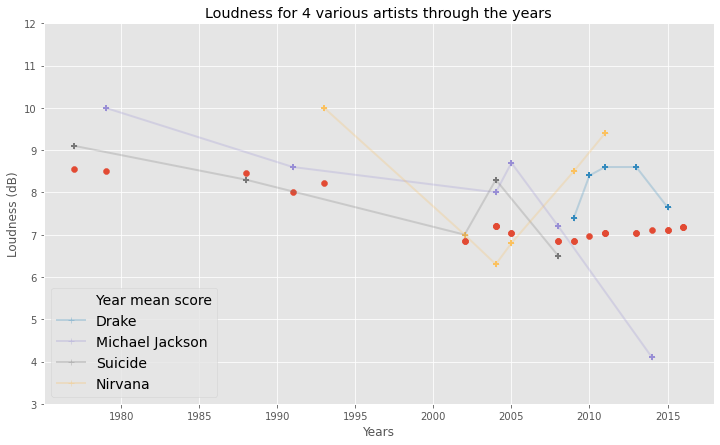

In [22]:
graph_scores_per_artist(reviews_df, ['drake', 'michael jackson', 'suicide', 'nirvana'])

The reviews dataset shows that Drake scored higher than the average score for the year. The other popular artists also scored higher than the average. But let's wrap it up. We will now plot the graph of the averaged loudness per yer values (regardless of the genre), against the averaged per year review scores values. 

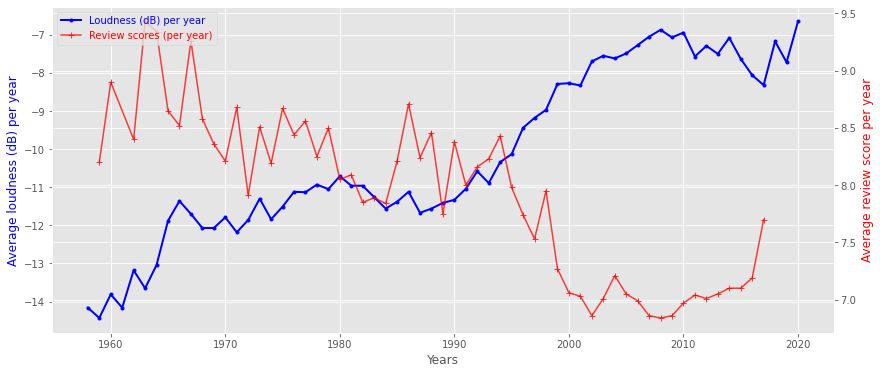

In [23]:
# Plotting the graphs
avg_scores_by_year = reviews_df.groupby('year')['year_mean_score'].agg(np.mean).round(2)
avg_loudness_by_year = spotify_df.groupby('year')['loudness'].agg(np.mean).round(2)
plt.figure(figsize=(14,6))
si_loudness = host_subplot(111)
si_scores = si_loudness.twinx()

si_loudness.set_xlabel('Years')
si_loudness.set_ylabel('Average loudness (dB) per year')
si_scores.set_ylabel('Average review score per year')

p1, = si_loudness.plot(avg_loudness_by_year.index[37:],
                       avg_loudness_by_year[37:],
                       marker='.',
                       lw=2,
                       color='blue',
                       label='Loudness (dB) per year')
p2, = si_scores.plot(avg_scores_by_year.index,
                     avg_scores_by_year, 
                     marker='+',
                     lw=1.5, 
                     color='red',
                     alpha=.75,
                     label="Review scores (per year)")

legend = plt.legend()

si_loudness.yaxis.get_label().set_color(p1.get_color())
legend.texts[0].set_color(p1.get_color())

si_scores.yaxis.get_label().set_color(p2.get_color())
legend.texts[1].set_color(p2.get_color())

plt.show()

In [24]:
highst_review_score = reviews_df.year_mean_score.max()
lowst_review_score = reviews_df.year_mean_score.min()
rev_year_high = reviews_df.loc[reviews_df['year_mean_score'] == highst_review_score]
rev_year_low = reviews_df.loc[reviews_df['year_mean_score'] == lowst_review_score]
print(f'{highst_review_score} - highest mean review score in {rev_year_high.year.unique()[0]}')
print(f'{lowst_review_score} - lowest mean review score in {rev_year_low.year.unique()[0]}')
softest_year_value = avg_loudness_by_year.min()
loudest_year_value = avg_loudness_by_year.max()
softest_year = avg_loudness_by_year.loc[avg_loudness_by_year == softest_year_value].keys().astype('int')[0]
loudest_year = avg_loudness_by_year.loc[avg_loudness_by_year == loudest_year_value].keys().astype('int')[0]
print(f'{softest_year_value} dB- lowest loudness yearly value, {softest_year}')
print(f'{loudest_year_value} dB - highest loudness yearly value, {loudest_year}')

9.43 - highest mean review score in 1963
6.84 - lowest mean review score in 2008
-19.28 dB- lowest loudness yearly value, 1922
-6.65 dB - highest loudness yearly value, 2020


## Conclusion

There is some significance in the final graph. 
* The averaged reviews value peaked at 9.43 for albums from 1963
* The averaged reviews value hit lowest average of 6.84 for albums in 2020. That is over 27% lower score than the highest value.
* The quietest albums came out in 1922, averaging -19.28 dB loudness.
* The loudest albums came out in 2020, averaging -6.65 dB loudness.

The hypothesis that "the louder the music the better the music is" is not supported by the data. And so, louder albums do not get better reviews. 